In [13]:
import os

# Đường dẫn tới thư mục chứa các loại quả
data_dir = "DataLoc"

# Đếm số lượng folder con (mỗi folder đại diện cho một loại quả)
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
total_fruits = len(folders)

print(f"Tổng số các loại quả: {total_fruits}")

Tổng số các loại quả: 0


# 1.Import thư viện

In [14]:
import os
import cv2
import numpy as np
from glob import glob
from skimage.measure import regionprops, label
from skimage.feature import canny
from scipy.fft import fft
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

# 2. Thử nghiệm segmentation (tách nền trắng)

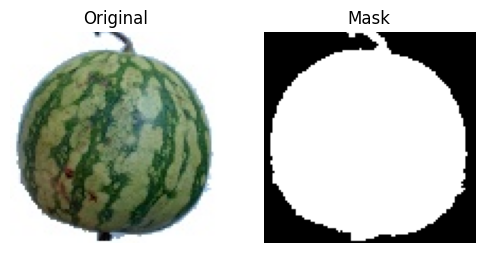

In [16]:
# Định nghĩa hàm segment_image
def segment_image(img, bg_threshold=240):
    mask = np.min(img, axis=2) < bg_threshold
    return mask.astype(np.uint8)

# Load ảnh mẫu và thử
sample_path = 'DataLoc/125_100.jpg'
img = cv2.imread(sample_path)
mask = segment_image(img)
# Hiển thị
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

# 3. Thử nghiệm trích xuất đặc trưng màu sắc (HSV histogram)

In [17]:
# Định nghĩa hàm extract_color_histogram
def extract_color_histogram(img, mask, bins=(8,8,8)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], mask, bins, [0,180,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Tính histogram màu
color_feat = extract_color_histogram(img, mask)
print('Kích thước feature màu:', color_feat.shape)
print('Phần đầu vector:', color_feat[:5])

Kích thước feature màu: (512,)
Phần đầu vector: [0. 0. 0. 0. 0.]


# 4. Thử nghiệm trích xuất đặc trưng hình dạng (eccentricity, Hu moments)

In [18]:
# Định nghĩa hàm extract_shape_features
def extract_shape_features(mask):
    labels_img = label(mask)
    props = regionprops(labels_img)
    if not props:
        return [0] + [0]*7
    prop = max(props, key=lambda x: x.area)
    ecc = prop.minor_axis_length / (prop.major_axis_length + 1e-5)
    moments = cv2.moments(mask.astype(np.uint8))
    hu = cv2.HuMoments(moments).flatten()
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    return [ecc] + hu.tolist()

# Tính đặc trưng hình dạng
shape_feat = extract_shape_features(mask)
print('Số chiều feature hình dạng:', len(shape_feat))
print('Giá trị:', shape_feat)


Số chiều feature hình dạng: 8
Giá trị: [0.9659639112250212, 0.7952709002079283, 4.512015143536076, 4.564119482797315, 7.267193195772647, 9.999725069095556, -9.440903760597074, -9.99992808029826]


# 5. Định nghĩa hàm extract_fourier_descriptor

In [19]:
def extract_fourier_descriptor(mask, num_coeffs=10):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return [0]*num_coeffs
    cnt = max(contours, key=cv2.contourArea)
    pts = cnt.squeeze()
    complex_pts = pts[:,0] + 1j*pts[:,1]
    coeffs = fft(complex_pts)
    coeffs /= np.abs(coeffs[1])
    desc = np.abs(coeffs[:num_coeffs])
    return desc.tolist()

# Tính Fourier descriptor
fourier_feat = extract_fourier_descriptor(mask)
print('Số chiều Fourier descriptor:', len(fourier_feat))
print('Giá trị:', fourier_feat)


Số chiều Fourier descriptor: 10
Giá trị: [22.693349744557867, 1.0, 1.0565511127903322, 0.5857944909483802, 0.41927841693268836, 0.4018689369846798, 0.17060702076783194, 0.18890857455431606, 0.14338812791745117, 0.1030686793696237]


# 6. Thử nghiệm grid-based binary code

In [20]:
# Định nghĩa hàm extract_grid_code
def extract_grid_code(mask, grid_size=(16,16), threshold=0.15):
    h,w = mask.shape
    gh,gw = grid_size
    cell_h,cell_w = h//gh, w//gw
    code = []
    for i in range(gh):
        for j in range(gw):
            cell = mask[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            frac = cell.sum()/(cell_h*cell_w)
            code.append(int(frac > threshold))
    return code

# Tính grid code
grid_feat = extract_grid_code(mask)
print('Độ dài grid code:', len(grid_feat))
print('Phần đầu grid code:', grid_feat[:20])

Độ dài grid code: 256
Phần đầu grid code: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# 7. Thử nghiệm edge histogram

In [21]:
# Định nghĩa hàm extract_edge_histogram
def extract_edge_histogram(img, mask, grid_size=(4,4)):
    edges = canny(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), sigma=2)
    edges = edges & mask.astype(bool)
    h,w = edges.shape
    gh,gw = grid_size
    cell_h,cell_w = h//gh, w//gw
    hist = []
    for i in range(gh):
        for j in range(gw):
            cell = edges[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            hist.append(cell.sum())
    hist = np.array(hist, dtype=float)
    if hist.max()>0:
        hist /= hist.max()
    return hist.tolist()

# Tính edge histogram
edge_feat = extract_edge_histogram(img, mask)
print('Số chiều edge histogram:', len(edge_feat))
print('Giá trị:', edge_feat)

Số chiều edge histogram: 16
Giá trị: [0.15702479338842976, 0.4628099173553719, 0.5867768595041323, 0.10743801652892562, 0.628099173553719, 1.0, 0.7603305785123967, 0.5867768595041323, 0.7024793388429752, 0.9421487603305785, 0.71900826446281, 0.6198347107438017, 0.2644628099173554, 0.7768595041322314, 0.7024793388429752, 0.4297520661157025]


# 8. Kết hợp và thử nghiệm toàn bộ pipeline

In [22]:
def extract_features(img_path):
    img = cv2.imread(img_path)
    mask = segment_image(img)
    color = extract_color_histogram(img, mask)
    shape = extract_shape_features(mask)
    fourier = extract_fourier_descriptor(mask)
    grid = extract_grid_code(mask)
    edge = extract_edge_histogram(img, mask)
    feat = np.hstack([color, shape, fourier, grid, edge])
    return feat

# Thử tính feature đầy đủ
full_feat = extract_features(sample_path)
print('Tổng chiều feature tức thời:', full_feat.shape)

Tổng chiều feature tức thời: (802,)


# 9. Xây dựng cơ sở dữ liệu và tìm kiếm tương đồng

In [30]:
dataset_dir = 'DataLoc2'
image_paths = glob(os.path.join(dataset_dir, '*', '*.jpg'))
features = []
labels = []

for p in image_paths[:500]:  # chỉ lấy mẫu nhanh
    img = cv2.imread(p)
    if img is None:
        print("❌ Không đọc được ảnh:", p)
        continue
    features.append(extract_features(p))
    labels.append(os.path.basename(os.path.dirname(p)))

features = np.vstack(features)
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)

# Hàm tìm kiếm
from sklearn.metrics.pairwise import cosine_distances
def find_similar(query_path, k=5):
    qf = extract_features(query_path)
    qf_norm = scaler.transform([qf])
    dists = cosine_distances(qf_norm, features_norm).flatten()
    idx = np.argsort(dists)[:k]
    return [(labels[i], dists[i]) for i in idx]

# %%
# Chạy thử tìm 5 quả tương đồng với ảnh mẫu
test_results = find_similar(sample_path, k=5)
print('Top 5 tương đồng:')
for lbl, dist in test_results:
    print(f"{lbl}: {dist:.4f}")

Top 5 tương đồng:
Limes 1: 0.7936
Limes 1: 0.8969
Limes 1: 0.9009
Limes 1: 0.9231
Limes 1: 0.9434


In [11]:
import os
import shutil

# Định nghĩa đường dẫn tới thư mục gốc Training và thư mục Training1
input_dir = '/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training'
output_dir = '/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training1'

# Kiểm tra nếu thư mục Training1 đã tồn tại, nếu không thì tạo mới
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Duyệt qua tất cả các thư mục con trong Training
for fruit_folder in os.listdir(input_dir):
    fruit_folder_path = os.path.join(input_dir, fruit_folder)
    
    # Kiểm tra nếu đó là thư mục
    if os.path.isdir(fruit_folder_path):
        # Tạo thư mục con tương ứng trong Training1
        output_fruit_folder_path = os.path.join(output_dir, fruit_folder)
        if not os.path.exists(output_fruit_folder_path):
            os.makedirs(output_fruit_folder_path)
        
        # Lấy danh sách các ảnh trong thư mục con
        images = os.listdir(fruit_folder_path)
        
        # Chọn một ảnh bất kỳ (ví dụ chọn ảnh đầu tiên)
        if images:
            img_path = os.path.join(fruit_folder_path, images[0])
            # Sao chép ảnh vào thư mục con tương ứng trong Training1
            shutil.copy(img_path, output_fruit_folder_path)

print("Tạo thư mục mới thành công!")


OSError: [Errno 30] Read-only file system: '/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training1'